In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check wheather colab has connected to Drive properly
!ls /content/drive/MyDrive

In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Digit_MNIST/train.csv')
data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data = np.array(data)
m,n = data.shape
np.random.shuffle(data)

In [6]:
data

array([[1, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       ...,
       [6, 0, 0, ..., 0, 0, 0],
       [7, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0]])

In [7]:
# Split train/val
train_data = data[:int(0.8*m), :]
val_data   = data[int(0.8*m):, :]

# Features (normalize only features)
X_train = (train_data[:, 1:].T) / 255.0   # (784, m_train)
X_val   = (val_data[:, 1:].T) / 255.0     # (784, m_val)

# Labels (keep as integers)
y_train = train_data[:, 0].astype(int)    # (m_train,)
y_val   = val_data[:, 0].astype(int)      # (m_val,)


In [8]:
print("Training data: ",X_train.shape,y_train.shape)
print("Validation data: ",X_val.shape,y_val.shape)

Training data:  (784, 48000) (48000,)
Validation data:  (784, 12000) (12000,)


In [9]:
y_train.shape

(48000,)

In [10]:
# Initialization
def initialize_parameters(seed=None):

    if seed is not None:
        np.random.seed(seed)

    W1 = np.random.randn(32, 784) * np.sqrt(2 / 784)
    b1 = np.zeros((32, 1))

    W2 = np.random.randn(10, 32) * np.sqrt(2 / 10)
    b2 = np.zeros((10, 1))

    return W1, b1, W2, b2


# Activation functions
def relu(x):

    return np.maximum(0, x)

def softmax(z):

    # subtract max per column for stability
    shifted = z - np.max(z, axis=0, keepdims=True)
    exp_z = np.exp(shifted)
    sums = np.sum(exp_z, axis=0, keepdims=True)
    return exp_z / sums


# Forward propagation
def forward_propagation(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = relu(Z1)

    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)

    return Z1, A1, Z2, A2


# One Hot Encoding
def one_hot_encoder(y, num_classes=None):
    if num_classes is None:
        num_classes = y.max() + 1
    m = y.size
    oh = np.zeros((m, num_classes))
    oh[np.arange(m), y] = 1
    return oh.T  # (num_classes, m)


# Calculating Loss
def compute_loss(A2, y, num_classes=None, eps=1e-9):
    """
    Cross-entropy: -1/m * sum log p(true_class)
    A2: (num_classes, m)
    y:  (m,)
    """
    one_hot_Y = one_hot_encoder(y, num_classes=num_classes)  # (C, m)
    # sum over classes per sample -> axis=0; then mean over samples
    log_probs = np.log(A2 + eps)
    loss = -np.mean(np.sum(one_hot_Y * log_probs, axis=0))
    return loss


# Backward propagation
def backward_propagation(W1, b1, W2, b2, Z1, A1, Z2, A2, X, y):

    m = X.shape[1]
    one_hot_Y = one_hot_encoder(y, num_classes=A2.shape[0])  # (10, m)

    # Output layer gradient (softmax + CE): dZ2 = A2 - Y_one_hot
    dZ2 = A2 - one_hot_Y                               # (10, m)

    dW2 = (1 / m) * dZ2.dot(A1.T)                      # (10, 10)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True) # (10, 1)

    # Hidden layer gradient through ReLU
    dZ1 = W2.T.dot(dZ2) * (Z1 > 0)                     # (10, m)

    dW1 = (1 / m) * dZ1.dot(X.T)                       # (10, 784)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True) # (10, 1)

    return dW1, db1, dW2, db2


# Weight updation
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    return W1, b1, W2, b2


# Prediction
def get_predictions(A2):
    """
    A2: (num_classes, m)
    Returns predicted labels: (m,)
    """
    return np.argmax(A2, axis=0)

def get_accuracy(predictions, y):
    return np.mean(predictions == y)



def gradient_descent(X, y, learning_rate=0.1, iterations=200, seed=None):
    """
    X: (784, m), y: (m,)
    """
    W1, b1, W2, b2 = initialize_parameters(seed=seed)

    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, X)

        dW1, db1, dW2, db2 = backward_propagation(W1, b1, W2, b2, Z1, A1, Z2, A2, X, y)

        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

        if i % 20 == 0:
            loss = compute_loss(A2, y, num_classes=A2.shape[0])
            acc = get_accuracy(get_predictions(A2), y)
            print(f"Iteration {i:4d} | Loss: {loss:.4f} | Accuracy: {acc:.4f}")

    return W1, b1, W2, b2

In [11]:
w1, b1, w2, b2 = gradient_descent(X_train, y_train, 0.1, 1500)

Iteration    0 | Loss: 3.3713 | Accuracy: 0.0907
Iteration   20 | Loss: 1.0509 | Accuracy: 0.7207
Iteration   40 | Loss: 0.6983 | Accuracy: 0.8299
Iteration   60 | Loss: 0.5587 | Accuracy: 0.8602
Iteration   80 | Loss: 0.4843 | Accuracy: 0.8748
Iteration  100 | Loss: 0.4382 | Accuracy: 0.8848
Iteration  120 | Loss: 0.4065 | Accuracy: 0.8918
Iteration  140 | Loss: 0.3831 | Accuracy: 0.8964
Iteration  160 | Loss: 0.3648 | Accuracy: 0.9008
Iteration  180 | Loss: 0.3501 | Accuracy: 0.9040
Iteration  200 | Loss: 0.3380 | Accuracy: 0.9071
Iteration  220 | Loss: 0.3278 | Accuracy: 0.9094
Iteration  240 | Loss: 0.3189 | Accuracy: 0.9114
Iteration  260 | Loss: 0.3111 | Accuracy: 0.9136
Iteration  280 | Loss: 0.3041 | Accuracy: 0.9152
Iteration  300 | Loss: 0.2979 | Accuracy: 0.9172
Iteration  320 | Loss: 0.2924 | Accuracy: 0.9186
Iteration  340 | Loss: 0.2873 | Accuracy: 0.9198
Iteration  360 | Loss: 0.2827 | Accuracy: 0.9212
Iteration  380 | Loss: 0.2785 | Accuracy: 0.9223
Iteration  400 | Los

Predicted label:  [7]
Actual label:  7


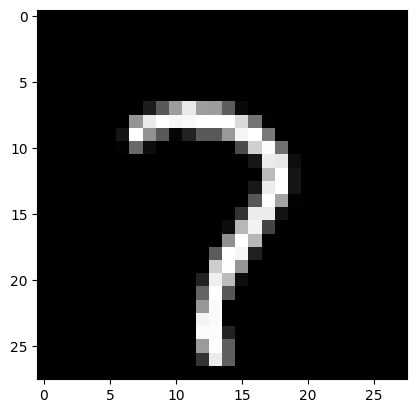

In [12]:
val_index = 99
Z1val, A1val, Z2val, A2val = forward_propagation(w1, b1, w2, b2, X_val[:, val_index, None])
print("Predicted label: ", get_predictions(A2val))
print("Actual label: ", y_val[val_index])

image_array = X_val[:,val_index].reshape(28,28)
plt.imshow(image_array, cmap='gray')
plt.show()

In [25]:
import pickle

# Save
with open("mlp_model1.pkl", "wb") as f:
    pickle.dump((w1, b1, w2, b2), f)



In [27]:
# Load
with open("mlp_model1.pkl", "rb") as f:
    W1, b1, W2, b2 = pickle.load(f)

Predicted label: [4]
Actual label: 4


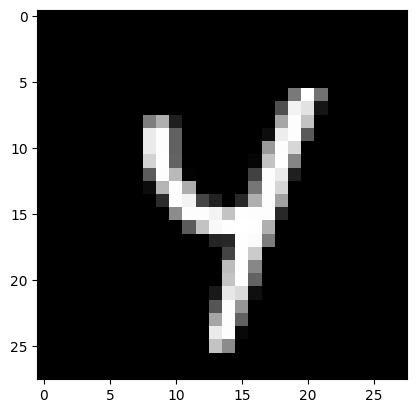

In [28]:
val_index = 888

# Forward pass using consistent variable names
Z1val, A1val, Z2val, A2val = forward_propagation(W1, b1, W2, b2, X_val[:, val_index, None])

# Predictions
print("Predicted label:", get_predictions(A2val))
print("Actual label:", y_val[val_index])

# Display the image (assuming MNIST 28x28)
image_array = X_val[:, val_index].reshape(28, 28)
plt.imshow(image_array, cmap='gray')
plt.show()

In [29]:
with open("mlp_model1.pkl", "rb") as f:
    W1, b1, W2, b2 = pickle.load(f)

# Forward pass on the entire validation set
Z1_val, A1_val, Z2_val, A2_val = forward_propagation(W1, b1, W2, b2, X_val)

# Predictions for all validation samples
predictions = get_predictions(A2_val)

# Compare with actual labels
accuracy = (predictions == y_val).mean()

print("Validation accuracy:", accuracy * 100, "%")

Validation accuracy: 94.01666666666667 %


In [30]:
## Test data----------------------------------------------

test_path = "/content/drive/My Drive/Colab_Notebooks/Digit_MNIST/test.csv"
test_df = pd.read_csv(test_path)

In [31]:
y_test = test_df['label'].values              # Actual digit labels
X_test = test_df.drop('label', axis=1).values # Pixel features
X_test = (X_test / 255.0).T                   # Transpose to shape (features, samples)

In [32]:
import pickle

with open("mlp_model1.pkl", "rb") as f:
    W1, b1, W2, b2 = pickle.load(f)

In [33]:
Z1_test, A1_test, Z2_test, A2_test = forward_propagation(W1, b1, W2, b2, X_test)
predictions = get_predictions(A2_test)

In [34]:
accuracy = (predictions == y_test).mean()
print("Test accuracy:", accuracy * 100, "%")

Test accuracy: 94.28999999999999 %


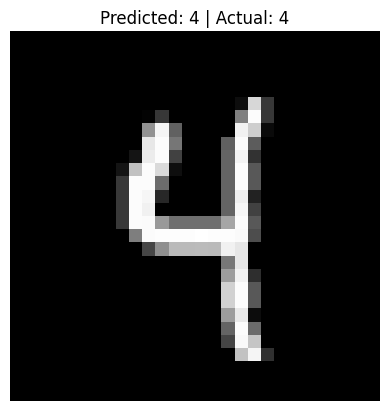

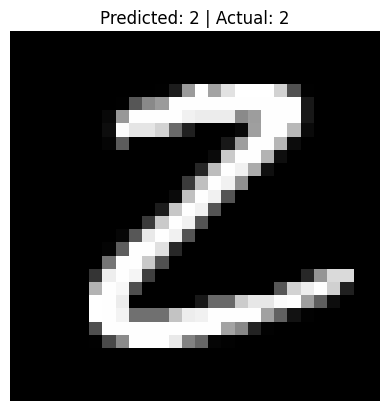

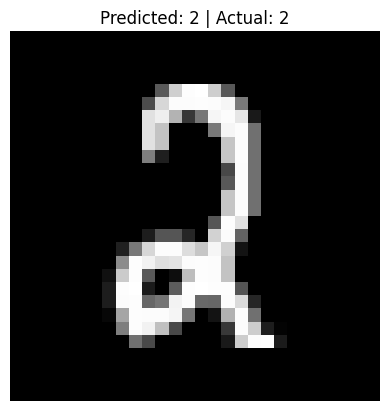

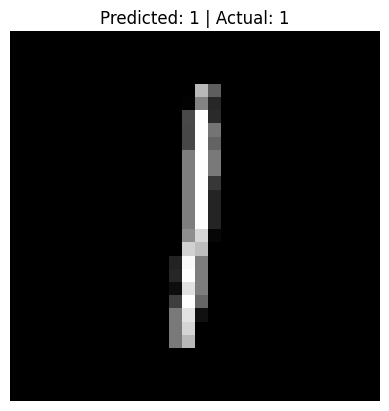

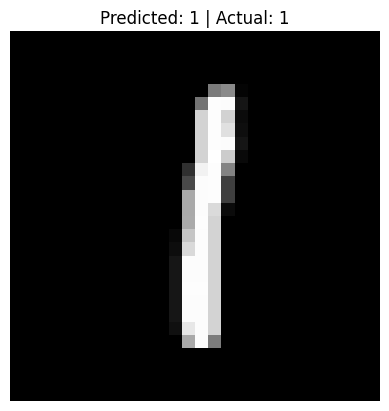

In [ ]:
for i in range(170,180,2):  # Show first 5 samples
    image = X_test[:, i].reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.title(f"Predicted: {predictions[i]} | Actual: {y_test[i]}")
    plt.axis('off')
    plt.show()

In [23]:
submission = pd.DataFrame({'ImageId': range(1, len(predictions)+1), 'Label': predictions})
submission.to_csv("submission.csv", index=False)